First I need to import Keras - a library for deep learning. It's a high level API built on top of TensorFlow which is another library for buidling machine learning models. Keras is very easy to use and great for a quick introduction into various deep learning models. There is more information available at https://keras.io/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quandl

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

/home/kostya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Pulling Microsoft stock prices and trading volume as well as Nasdaq Composite index. Nasdaq can provide some additional information on general trends in the technology sector.

In [2]:
msft = quandl.get("EOD/MSFT", start_date='2014-01-01', end_date='2017-12-31', authtoken='_FB3aTCzbq3WsvTtwL-U')
nasdaq = quandl.get('NASDAQOMX/COMP', start_date='2014-01-01', end_date='2017-12-31', authtoken='_FB3aTCzbq3WsvTtwL-U')

Preprocessing train data. Original data inputs have different ranges which introduces bias into the model. It's important to scale all model inputs so they are comparable.

I am going to look at 40 previous trading days to predict Microsoft close price of the next day. Input data vector will also have 40 previous daily volumes for Microsoft and 40 previous Nasdaq Index values.

The model will be trained on 4 years of data: 2014 through 2017.

In [3]:
train = msft[['Adj_Close','Volume']]
train = train.join(nasdaq[['Index Value']])

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
train_sc = scaler.fit_transform(train)

X_train = []
y_train = []
for i in range(40, len(train)):
    X_train.append(
            [train_sc[i-40:i, 0],
             train_sc[i-40:i, 1],
             train_sc[i-40:i, 2]
             ])
    y_train.append(train_sc[i, 0])
X_train = np.array(X_train)

X_train = X_train.transpose(0,2,1)
y_train = np.array(y_train)

Neural network consists of multiple layers of neurons. I am going to create one with 4 "hidden" layers plus input and output layers. Input layer will have 120 values: 40 MSFT stock prices, 40 MSFT volume numbers and 40 Nasdaq index prices. Each "hidden" layer will have either 30 or 60 neurons - assigned in the next step. Output layer will have only one neuron cause i am trying to predict just one daily price of MSFT stock.

Keras library allows to use different types of layers for neural networks. Probably the best type of layer for RNN - recurrent neural network is LSTM layer or long short-term memory. Here is more information about it: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Dropout is used to randomly disable a certain fraction of neurons in the layer during model training to prevent overfitting. I will be dropping 20% of neurons in each layer in this case.

In [4]:
def regressor_fn(opt, unt):
    regressor = Sequential()
    #First layer
    regressor.add(LSTM(units = unt, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    regressor.add(Dropout(0.2))
    
    #Second layer
    regressor.add(LSTM(units = unt, return_sequences = True))
    regressor.add(Dropout(0.2))
    
    #Third layer
    regressor.add(LSTM(units = unt, return_sequences = True))
    regressor.add(Dropout(0.2))
    
    #Fourth layer
    regressor.add(LSTM(units = unt))
    regressor.add(Dropout(0.2))
    
    #Output layer
    regressor.add(Dense(units = 1))
    
    regressor.compile(optimizer = opt, loss = 'mean_squared_error')
    return regressor

I am using GridSearchCV class from scikit-learn library to find the best combination of hyper-parameters for my model such as batch size, number of epochs, number of neurons, etc and also to perform cross validation of the model.

Cross validation is important cause it allows to test model performance on multiple data samples before running it against final test data. It helps to make sure the model is showing comparable accuracy in and out of sample. I am using 4-fold cross validation for this model.

KerasRegressor is a wrapper from Keras library that allows to use scikit-learn GridSearchCV in Keras model.

In [5]:
regressor = KerasRegressor(build_fn = regressor_fn)
tuned_params = {'batch_size': [16, 32],
                'epochs': [100, 200],
                'unt': [30, 60],
                'opt': ['adam']}
grid = GridSearchCV(estimator = regressor,
                    param_grid = tuned_params,
                    scoring = 'neg_mean_squared_error',
                    n_jobs = -1,
                    cv = 4)

Fitting the model

In [6]:
import time
start_time = time.time()
grid = grid.fit(X_train, y_train)
end_time = time.time() - start_time

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
725/725 [==============================] - 49s 68ms/step - loss: 0.0397
Epoch 2/100
726/726 [==============================] - 51s 71ms/step - loss: 0.0132
Epoch 2/100
725/725 [==============================] - 52s 71ms/step - loss: 0.0320
Epoch 2/100
725/725 [==============================] - 38s 53ms/step - loss: 0.0074
Epoch 3/100
725/725 [==============================] - 38s 53ms/step - loss: 0.0059
Epoch 3/100
725/725 [==============================] - 38s 53ms/step - loss: 0.0057
Epoch 3/100
726/726 [==============================] - 39s 54ms/step - loss: 0.0036
Epoch 3/100
725/725 [==============================] - 39s 53ms/step - loss: 0.0077
Epoch 4/100
725/725 [==============================] - 40s 55ms/step - loss: 0.0070
Epoch 4/100
725/725 [==============================] - 40s 55ms/step - loss: 0.0068
Epoch 4/100
726/726 [==============================] - 40s 56ms/step - loss: 0.0027
Epoch 4/100
725/725 [===================

Epoch 24/100
726/726 [==============================] - 45s 62ms/step - loss: 0.0014
Epoch 24/100
725/725 [==============================] - 45s 62ms/step - loss: 0.0027
Epoch 25/100
725/725 [==============================] - 44s 61ms/step - loss: 0.0028
Epoch 25/100
726/726 [==============================] - 45s 62ms/step - loss: 0.0014
Epoch 25/100
725/725 [==============================] - 50s 69ms/step - loss: 0.0036
Epoch 26/100
725/725 [==============================] - 50s 69ms/step - loss: 0.0032
Epoch 26/100
725/725 [==============================] - 50s 69ms/step - loss: 0.0030
Epoch 26/100
726/726 [==============================] - 49s 68ms/step - loss: 0.0014
Epoch 26/100
725/725 [==============================] - 45s 63ms/step - loss: 0.0030
Epoch 27/100
725/725 [==============================] - 45s 63ms/step - loss: 0.0027
Epoch 27/100
725/725 [==============================] - 45s 62ms/step - loss: 0.0026
Epoch 27/100
725/725 [==============================] - 45s 62ms/

725/725 [==============================] - 45s 62ms/step - loss: 0.0020
Epoch 47/100
726/726 [==============================] - 46s 63ms/step - loss: 9.0557e-04
Epoch 47/100
725/725 [==============================] - 45s 62ms/step - loss: 0.0022
Epoch 48/100
725/725 [==============================] - 47s 64ms/step - loss: 0.0020
Epoch 48/100
725/725 [==============================] - 46s 63ms/step - loss: 0.0020
Epoch 48/100
726/726 [==============================] - 46s 63ms/step - loss: 9.9650e-04
Epoch 48/100
725/725 [==============================] - 46s 64ms/step - loss: 0.0023
Epoch 49/100
725/725 [==============================] - 46s 63ms/step - loss: 0.0021
Epoch 49/100
725/725 [==============================] - 46s 63ms/step - loss: 0.0021
Epoch 49/100
726/726 [==============================] - 46s 64ms/step - loss: 9.2393e-04
Epoch 49/100
725/725 [==============================] - 45s 63ms/step - loss: 0.0022
Epoch 50/100
725/725 [==============================] - 45s 62ms/s

725/725 [==============================] - 49s 67ms/step - loss: 0.0015
Epoch 71/100
725/725 [==============================] - 48s 67ms/step - loss: 0.0015
Epoch 71/100
726/726 [==============================] - 46s 63ms/step - loss: 8.4097e-04
Epoch 71/100
726/726 [==============================] - 47s 64ms/step - loss: 6.0780e-04
Epoch 72/100
725/725 [==============================] - 46s 64ms/step - loss: 0.0018
Epoch 73/100
725/725 [==============================] - 47s 64ms/step - loss: 0.0020
Epoch 73/100
725/725 [==============================] - 47s 65ms/step - loss: 0.0019
Epoch 73/100
726/726 [==============================] - 48s 66ms/step - loss: 6.7482e-04
Epoch 73/100
725/725 [==============================] - 46s 64ms/step - loss: 0.0015
Epoch 74/100
725/725 [==============================] - 45s 63ms/step - loss: 0.0015
Epoch 74/100
725/725 [==============================] - 46s 63ms/step - loss: 0.0016
Epoch 74/100
726/726 [==============================] - 45s 62ms/s

725/725 [==============================] - 46s 63ms/step - loss: 0.0014
Epoch 93/100
725/725 [==============================] - 46s 63ms/step - loss: 0.0015
Epoch 93/100
725/725 [==============================] - 45s 62ms/step - loss: 0.0017
Epoch 93/100
726/726 [==============================] - 46s 64ms/step - loss: 5.4062e-04
Epoch 93/100
725/725 [==============================] - 46s 63ms/step - loss: 0.0011
Epoch 94/100
725/725 [==============================] - 46s 63ms/step - loss: 0.0013
Epoch 94/100
725/725 [==============================] - 47s 65ms/step - loss: 0.0013
Epoch 94/100
726/726 [==============================] - 46s 63ms/step - loss: 5.7643e-04
Epoch 94/100
725/725 [==============================] - 46s 63ms/step - loss: 0.0013
Epoch 95/100
725/725 [==============================] - 47s 66ms/step - loss: 0.0014
Epoch 95/100
725/725 [==============================] - 47s 65ms/step - loss: 0.0014
Epoch 95/100
726/726 [==============================] - 44s 60ms/step 

725/725 [==============================] - 51s 70ms/step - loss: 0.0031
Epoch 16/100
726/726 [==============================] - 50s 70ms/step - loss: 0.0012
Epoch 16/100
725/725 [==============================] - 50s 68ms/step - loss: 0.0043
Epoch 17/100
725/725 [==============================] - 51s 71ms/step - loss: 0.0045
Epoch 17/100
725/725 [==============================] - 51s 70ms/step - loss: 0.0033
Epoch 17/100
726/726 [==============================] - 50s 69ms/step - loss: 0.0012
Epoch 17/100
725/725 [==============================] - 50s 69ms/step - loss: 0.0029
Epoch 18/100
725/725 [==============================] - 50s 69ms/step - loss: 0.0031
Epoch 18/100
725/725 [==============================] - 50s 68ms/step - loss: 0.0026
Epoch 18/100
726/726 [==============================] - 50s 68ms/step - loss: 0.0013
Epoch 18/100
725/725 [==============================] - 44s 61ms/step - loss: 0.0024
Epoch 19/100
725/725 [==============================] - 45s 61ms/step - loss: 

Epoch 39/100
725/725 [==============================] - 36s 50ms/step - loss: 0.0020
Epoch 40/100
725/725 [==============================] - 35s 49ms/step - loss: 0.0018
Epoch 40/100
726/726 [==============================] - 36s 50ms/step - loss: 7.3995e-04
Epoch 40/100
725/725 [==============================] - 36s 49ms/step - loss: 0.0018
Epoch 41/100
725/725 [==============================] - 36s 50ms/step - loss: 0.0017
Epoch 41/100
726/726 [==============================] - 36s 50ms/step - loss: 7.7157e-04
Epoch 41/100
725/725 [==============================] - 36s 50ms/step - loss: 0.0016
Epoch 42/100
725/725 [==============================] - 35s 49ms/step - loss: 0.0015
Epoch 42/100
725/725 [==============================] - 35s 49ms/step - loss: 0.0015
Epoch 42/100
726/726 [==============================] - 36s 50ms/step - loss: 7.7419e-04
Epoch 42/100
725/725 [==============================] - 36s 50ms/step - loss: 0.0013
Epoch 43/100
725/725 [==============================]

726/726 [==============================] - 36s 50ms/step - loss: 5.5855e-04
Epoch 61/100
725/725 [==============================] - 36s 49ms/step - loss: 0.0017
Epoch 62/100
725/725 [==============================] - 35s 49ms/step - loss: 0.0018
Epoch 62/100
725/725 [==============================] - 36s 49ms/step - loss: 0.0017
Epoch 62/100
726/726 [==============================] - 36s 50ms/step - loss: 5.4155e-04
Epoch 62/100
725/725 [==============================] - 35s 49ms/step - loss: 0.0016
Epoch 63/100
725/725 [==============================] - 36s 49ms/step - loss: 0.0016
Epoch 63/100
725/725 [==============================] - 36s 50ms/step - loss: 0.0014
Epoch 63/100
726/726 [==============================] - 36s 50ms/step - loss: 5.5493e-04
Epoch 63/100
725/725 [==============================] - 36s 50ms/step - loss: 0.0013
Epoch 64/100
725/725 [==============================] - 36s 50ms/step - loss: 0.0014
Epoch 64/100
725/725 [==============================] - 36s 49ms/s

725/725 [==============================] - 36s 50ms/step - loss: 0.0011
Epoch 84/100
726/726 [==============================] - 37s 50ms/step - loss: 4.6891e-04
Epoch 84/100
725/725 [==============================] - 36s 50ms/step - loss: 0.0011
Epoch 85/100
725/725 [==============================] - 36s 49ms/step - loss: 0.0010
Epoch 85/100
725/725 [==============================] - 36s 50ms/step - loss: 0.0010
Epoch 85/100
726/726 [==============================] - 36s 50ms/step - loss: 6.5762e-04
Epoch 85/100
725/725 [==============================] - 36s 50ms/step - loss: 9.8150e-04
Epoch 86/100
725/725 [==============================] - 36s 49ms/step - loss: 9.9949e-04
Epoch 86/100
726/726 [==============================] - 36s 50ms/step - loss: 4.6515e-04
Epoch 86/100
725/725 [==============================] - 36s 50ms/step - loss: 0.0013
Epoch 87/100
725/725 [==============================] - 36s 49ms/step - loss: 0.0013
Epoch 87/100
725/725 [==============================] - 36

725/725 [==============================] - 33s 46ms/step - loss: 0.0054
Epoch 7/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0050
Epoch 7/200
725/725 [==============================] - 32s 44ms/step - loss: 0.0052
Epoch 7/200
726/726 [==============================] - 33s 45ms/step - loss: 0.0023
Epoch 7/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0055
Epoch 8/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0046
Epoch 8/200
726/726 [==============================] - 32s 45ms/step - loss: 0.0025
Epoch 8/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0051
Epoch 9/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0048
Epoch 9/200
726/726 [==============================] - 33s 46ms/step - loss: 0.0021
Epoch 9/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0041
Epoch 10/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0040
Epo

725/725 [==============================] - 33s 45ms/step - loss: 0.0031
Epoch 29/200
726/726 [==============================] - 33s 46ms/step - loss: 0.0013
Epoch 29/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0028
Epoch 30/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0031
Epoch 30/200
726/726 [==============================] - 33s 45ms/step - loss: 0.0013
Epoch 30/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0028
Epoch 31/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0031
Epoch 31/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0027
Epoch 31/200
726/726 [==============================] - 33s 45ms/step - loss: 0.0013
Epoch 31/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0030
Epoch 32/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0032
Epoch 32/200
725/725 [==============================] - 32s 45ms/step - loss: 

726/726 [==============================] - 33s 45ms/step - loss: 9.0841e-04
Epoch 51/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0027
Epoch 52/200
725/725 [==============================] - 34s 47ms/step - loss: 0.0025
Epoch 52/200
725/725 [==============================] - 34s 46ms/step - loss: 0.0028
Epoch 52/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0020
Epoch 53/200
726/726 [==============================] - 33s 45ms/step - loss: 0.0010
Epoch 52/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0021
Epoch 53/200
725/725 [==============================] - 34s 46ms/step - loss: 0.0021
Epoch 53/200
725/725 [==============================] - 32s 44ms/step - loss: 0.0019
Epoch 54/200
726/726 [==============================] - 33s 46ms/step - loss: 9.1873e-04
Epoch 53/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0020
Epoch 54/200
725/725 [==============================] - 33s 46ms/step 

725/725 [==============================] - 33s 45ms/step - loss: 0.0017
Epoch 74/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0017
Epoch 74/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0018
Epoch 75/200
726/726 [==============================] - 33s 45ms/step - loss: 7.2906e-04
Epoch 74/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0018
Epoch 75/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0017
Epoch 75/200
725/725 [==============================] - 34s 46ms/step - loss: 0.0015
Epoch 76/200
726/726 [==============================] - 32s 45ms/step - loss: 7.1142e-04
Epoch 75/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0016
Epoch 76/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0015
Epoch 76/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0016
Epoch 77/200
726/726 [==============================] - 33s 45ms/step 

725/725 [==============================] - 32s 45ms/step - loss: 0.0015
Epoch 97/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0014
Epoch 98/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0014
Epoch 98/200
726/726 [==============================] - 33s 45ms/step - loss: 6.4005e-04
Epoch 97/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0013
Epoch 98/200
725/725 [==============================] - 34s 46ms/step - loss: 0.0016
Epoch 99/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0014
Epoch 99/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0016
Epoch 100/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0016
Epoch 100/200
726/726 [==============================] - 33s 46ms/step - loss: 6.6712e-04
Epoch 99/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0014
Epoch 100/200
725/725 [==============================] - 33s 46ms/st

725/725 [==============================] - 33s 46ms/step - loss: 0.0013
Epoch 119/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0014
Epoch 120/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0013
Epoch 120/200
726/726 [==============================] - 33s 45ms/step - loss: 4.9609e-04
Epoch 119/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0011
Epoch 120/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0013
Epoch 121/200
726/726 [==============================] - 33s 45ms/step - loss: 5.3528e-04
Epoch 120/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0012
Epoch 121/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0015
Epoch 122/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0014
Epoch 122/200
726/726 [==============================] - 32s 44ms/step - loss: 4.8500e-04
Epoch 121/200
725/725 [==============================] -

725/725 [==============================] - 33s 45ms/step - loss: 0.0012
Epoch 142/200
726/726 [==============================] - 33s 46ms/step - loss: 5.1802e-04
Epoch 141/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0011
Epoch 142/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0012
Epoch 143/200
726/726 [==============================] - 33s 46ms/step - loss: 5.8468e-04
Epoch 142/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0011
Epoch 143/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0013
Epoch 144/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0014
Epoch 144/200
726/726 [==============================] - 32s 45ms/step - loss: 4.8518e-04
Epoch 143/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0013
Epoch 144/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0014
Epoch 145/200
725/725 [==============================] -

725/725 [==============================] - 33s 46ms/step - loss: 0.0011
Epoch 164/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0011
Epoch 165/200
726/726 [==============================] - 33s 45ms/step - loss: 4.5724e-04
Epoch 164/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0011
Epoch 165/200
725/725 [==============================] - 33s 45ms/step - loss: 9.7405e-04
Epoch 165/200
725/725 [==============================] - 34s 47ms/step - loss: 0.0012
Epoch 166/200
726/726 [==============================] - 33s 45ms/step - loss: 5.2059e-04
Epoch 165/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0011
Epoch 166/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0012
Epoch 167/200
726/726 [==============================] - 33s 45ms/step - loss: 5.2497e-04
Epoch 166/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0013
Epoch 167/200
725/725 [=============================

725/725 [==============================] - 34s 46ms/step - loss: 9.7169e-04
Epoch 186/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0012
Epoch 187/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0012
Epoch 187/200
726/726 [==============================] - 33s 45ms/step - loss: 4.2304e-04
Epoch 186/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0010
Epoch 187/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0011
Epoch 188/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0011
Epoch 188/200
726/726 [==============================] - 33s 45ms/step - loss: 4.3914e-04
Epoch 187/200
725/725 [==============================] - 33s 46ms/step - loss: 9.1523e-04
Epoch 188/200
725/725 [==============================] - 34s 46ms/step - loss: 0.0011
Epoch 189/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0011
Epoch 189/200
726/726 [=============================

725/725 [==============================] - 37s 51ms/step - loss: 0.0034
Epoch 9/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0033
Epoch 10/200
726/726 [==============================] - 37s 50ms/step - loss: 0.0014
Epoch 9/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0029
Epoch 10/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0030
Epoch 10/200
725/725 [==============================] - 36s 49ms/step - loss: 0.0028
Epoch 11/200
726/726 [==============================] - 36s 49ms/step - loss: 0.0018
Epoch 10/200
725/725 [==============================] - 36s 49ms/step - loss: 0.0025
Epoch 11/200
725/725 [==============================] - 36s 49ms/step - loss: 0.0032
Epoch 12/200
726/726 [==============================] - 36s 50ms/step - loss: 0.0017
Epoch 11/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0031
Epoch 12/200
725/725 [==============================] - 36s 50ms/step - loss: 0.

725/725 [==============================] - 37s 51ms/step - loss: 0.0019
Epoch 33/200
726/726 [==============================] - 36s 50ms/step - loss: 7.8041e-04
Epoch 32/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0017
Epoch 33/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0022
Epoch 34/200
726/726 [==============================] - 36s 49ms/step - loss: 8.4651e-04
Epoch 33/200
725/725 [==============================] - 36s 49ms/step - loss: 0.0020
Epoch 34/200
725/725 [==============================] - 36s 49ms/step - loss: 0.0019
Epoch 35/200
725/725 [==============================] - 37s 50ms/step - loss: 0.0017
Epoch 35/200
726/726 [==============================] - 36s 50ms/step - loss: 8.9349e-04
Epoch 34/200
725/725 [==============================] - 36s 49ms/step - loss: 0.0016
Epoch 35/200
725/725 [==============================] - 37s 51ms/step - loss: 0.0023
Epoch 36/200
726/726 [==============================] - 36s 50ms/s

725/725 [==============================] - 36s 50ms/step - loss: 0.0015
Epoch 55/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0016
Epoch 56/200
726/726 [==============================] - 36s 50ms/step - loss: 5.6554e-04
Epoch 55/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0016
Epoch 56/200
725/725 [==============================] - 37s 51ms/step - loss: 0.0014
Epoch 56/200
725/725 [==============================] - 35s 49ms/step - loss: 0.0015
Epoch 57/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0014
Epoch 57/200
Epoch 56/200
725/725 [==============================] - 36s 49ms/step - loss: 0.0013
Epoch 57/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0014
Epoch 58/200
726/726 [==============================] - 36s 49ms/step - loss: 5.8552e-04
Epoch 57/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0013
Epoch 58/200
725/725 [==============================] - 3

725/725 [==============================] - 36s 50ms/step - loss: 0.0011
Epoch 79/200
725/725 [==============================] - 36s 49ms/step - loss: 0.0011
Epoch 79/200
726/726 [==============================] - 36s 49ms/step - loss: 4.6413e-04
Epoch 78/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0011
Epoch 79/200
725/725 [==============================] - 37s 50ms/step - loss: 0.0013
Epoch 80/200
725/725 [==============================] - 37s 50ms/step - loss: 0.0013
Epoch 80/200
726/726 [==============================] - 36s 50ms/step - loss: 4.7776e-04
Epoch 79/200
725/725 [==============================] - 36s 50ms/step - loss: 0.0013
Epoch 80/200
725/725 [==============================] - 37s 51ms/step - loss: 0.0014
Epoch 81/200
725/725 [==============================] - 35s 49ms/step - loss: 0.0013
Epoch 81/200
726/726 [==============================] - 37s 50ms/step - loss: 4.7695e-04
Epoch 80/200
725/725 [==============================] - 36s 49ms/s

726/726 [==============================] - 35s 49ms/step - loss: 4.1186e-04
Epoch 100/200
725/725 [==============================] - 36s 49ms/step - loss: 0.0011
Epoch 101/200
725/725 [==============================] - 36s 49ms/step - loss: 9.7216e-04
Epoch 102/200
725/725 [==============================] - 37s 50ms/step - loss: 9.7039e-04
Epoch 102/200
726/726 [==============================] - 36s 50ms/step - loss: 4.0453e-04
Epoch 101/200
725/725 [==============================] - 36s 50ms/step - loss: 9.5440e-04
Epoch 102/200
725/725 [==============================] - 36s 50ms/step - loss: 9.2748e-04
Epoch 103/200
725/725 [==============================] - 37s 50ms/step - loss: 9.8298e-04
Epoch 103/200
726/726 [==============================] - 36s 50ms/step - loss: 4.4229e-04
Epoch 102/200
725/725 [==============================] - 36s 50ms/step - loss: 9.2591e-04
Epoch 103/200
725/725 [==============================] - 37s 50ms/step - loss: 9.4288e-04
Epoch 104/200
725/725 [=====

725/725 [==============================] - 36s 49ms/step - loss: 7.8052e-04
Epoch 123/200
725/725 [==============================] - 37s 51ms/step - loss: 9.1344e-04
Epoch 124/200
725/725 [==============================] - 36s 50ms/step - loss: 9.6483e-04
Epoch 124/200
726/726 [==============================] - 36s 50ms/step - loss: 3.8608e-04
Epoch 123/200
725/725 [==============================] - 36s 49ms/step - loss: 0.0011
Epoch 124/200
725/725 [==============================] - 36s 50ms/step - loss: 9.7036e-04
Epoch 125/200
725/725 [==============================] - 36s 50ms/step - loss: 8.8631e-04
Epoch 125/200
726/726 [==============================] - 36s 50ms/step - loss: 3.8556e-04
Epoch 124/200
725/725 [==============================] - 36s 50ms/step - loss: 9.5467e-04
Epoch 125/200
725/725 [==============================] - 36s 49ms/step - loss: 9.6927e-04
Epoch 126/200
725/725 [==============================] - 37s 51ms/step - loss: 8.7224e-04
Epoch 126/200
726/726 [=====

725/725 [==============================] - 36s 49ms/step - loss: 6.9749e-04
Epoch 146/200
726/726 [==============================] - 37s 51ms/step - loss: 3.6078e-04
Epoch 145/200
725/725 [==============================] - 37s 51ms/step - loss: 8.1873e-04
Epoch 146/200
725/725 [==============================] - 36s 50ms/step - loss: 7.6209e-04
Epoch 147/200
725/725 [==============================] - 37s 51ms/step - loss: 7.8955e-04
Epoch 147/200
726/726 [==============================] - 35s 49ms/step - loss: 3.8121e-04
Epoch 146/200
725/725 [==============================] - 36s 50ms/step - loss: 7.8988e-04
Epoch 148/200
725/725 [==============================] - 36s 49ms/step - loss: 8.8028e-04
Epoch 148/200
726/726 [==============================] - 36s 50ms/step - loss: 3.3417e-04
Epoch 147/200
725/725 [==============================] - 36s 50ms/step - loss: 7.5749e-04
Epoch 149/200
725/725 [==============================] - 36s 50ms/step - loss: 8.1803e-04
Epoch 149/200
725/725 [=

725/725 [==============================] - 36s 49ms/step - loss: 8.6310e-04
Epoch 166/200
725/725 [==============================] - 36s 50ms/step - loss: 6.7203e-04
Epoch 167/200
725/725 [==============================] - 35s 49ms/step - loss: 8.0213e-04
Epoch 167/200
726/726 [==============================] - 36s 50ms/step - loss: 3.6470e-04
Epoch 166/200
725/725 [==============================] - 37s 51ms/step - loss: 9.0068e-04
Epoch 167/200
725/725 [==============================] - 37s 51ms/step - loss: 7.4017e-04
Epoch 168/200
725/725 [==============================] - 36s 49ms/step - loss: 7.9911e-04
Epoch 168/200
725/725 [==============================] - 35s 49ms/step - loss: 8.1472e-04
Epoch 168/200
725/725 [==============================] - 36s 50ms/step - loss: 7.4859e-04
Epoch 169/200
726/726 [==============================] - 36s 50ms/step - loss: 3.4052e-04
Epoch 168/200
725/725 [==============================] - 36s 50ms/step - loss: 7.9365e-04
Epoch 169/200
725/725 [=

725/725 [==============================] - 36s 50ms/step - loss: 9.2762e-04
Epoch 188/200
725/725 [==============================] - 36s 50ms/step - loss: 7.3969e-04
Epoch 189/200
725/725 [==============================] - 35s 49ms/step - loss: 6.6704e-04
Epoch 189/200
726/726 [==============================] - 37s 51ms/step - loss: 3.1734e-04
Epoch 188/200
725/725 [==============================] - 36s 50ms/step - loss: 8.2071e-04
Epoch 190/200
725/725 [==============================] - 36s 50ms/step - loss: 8.1224e-04
Epoch 190/200
726/726 [==============================] - 36s 50ms/step - loss: 3.4497e-04
Epoch 189/200
725/725 [==============================] - 36s 50ms/step - loss: 7.7962e-04
Epoch 190/200
725/725 [==============================] - 36s 49ms/step - loss: 9.0874e-04
Epoch 191/200
725/725 [==============================] - 36s 50ms/step - loss: 7.7567e-04
Epoch 191/200
726/726 [==============================] - 36s 49ms/step - loss: 3.7394e-04
Epoch 190/200
725/725 [=

725/725 [==============================] - 17s 23ms/step - loss: 0.0048
Epoch 11/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0047
Epoch 9/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0044
Epoch 11/100
726/726 [==============================] - 17s 24ms/step - loss: 0.0021
Epoch 9/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0049
Epoch 12/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0046
Epoch 10/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0045
Epoch 12/100
726/726 [==============================] - 17s 24ms/step - loss: 0.0022
Epoch 10/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0052
Epoch 13/100
725/725 [==============================] - 17s 23ms/step - loss: 0.0042
Epoch 11/100
725/725 [==============================] - 17s 23ms/step - loss: 0.0049
Epoch 13/100
726/726 [==============================] - 17s 24ms/step - loss: 0.

725/725 [==============================] - 17s 24ms/step - loss: 0.0032
Epoch 32/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0028
Epoch 34/100
726/726 [==============================] - 18s 24ms/step - loss: 0.0015
Epoch 32/100
725/725 [==============================] - 17s 23ms/step - loss: 0.0037
Epoch 35/100
725/725 [==============================] - 17s 23ms/step - loss: 0.0029
Epoch 33/100
725/725 [==============================] - 17s 23ms/step - loss: 0.0035
Epoch 35/100
726/726 [==============================] - 17s 24ms/step - loss: 0.0015
Epoch 33/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0037
Epoch 36/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0027
Epoch 34/100
726/726 [==============================] - 17s 24ms/step - loss: 0.0014
Epoch 34/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0034
Epoch 37/100
725/725 [==============================] - 17s 23ms/step - loss: 

725/725 [==============================] - 17s 23ms/step - loss: 0.0026
Epoch 55/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0030
Epoch 57/100
726/726 [==============================] - 17s 24ms/step - loss: 0.0013
Epoch 55/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0027
Epoch 58/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0028
Epoch 56/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0025
Epoch 58/100
725/725 [==============================] - 17s 23ms/step - loss: 0.0026
Epoch 59/100
726/726 [==============================] - 18s 24ms/step - loss: 0.0012
Epoch 56/100
725/725 [==============================] - 18s 24ms/step - loss: 0.0029
Epoch 57/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0024
Epoch 59/100
726/726 [==============================] - 17s 24ms/step - loss: 0.0011
Epoch 57/100
725/725 [==============================] - 17s 24ms/step - loss: 

725/725 [==============================] - 17s 24ms/step - loss: 0.0020
Epoch 80/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0025
Epoch 78/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0019
Epoch 80/100
726/726 [==============================] - 17s 24ms/step - loss: 9.8092e-04
Epoch 78/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0022
Epoch 81/100
725/725 [==============================] - 18s 25ms/step - loss: 0.0020
Epoch 79/100
725/725 [==============================] - 18s 24ms/step - loss: 0.0020
Epoch 81/100
726/726 [==============================] - 17s 23ms/step - loss: 9.5217e-04
Epoch 79/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0024
Epoch 82/100
725/725 [==============================] - 18s 24ms/step - loss: 0.0019
Epoch 80/100
725/725 [==============================] - 17s 24ms/step - loss: 0.0023
Epoch 82/100
726/726 [==============================] - 17s 23ms/step 

726/726 [==============================] - 9s 13ms/step - loss: 7.4817e-04
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
725/725 [==============================] - 47s 65ms/step - loss: 0.0471
Epoch 2/100
725/725 [==============================] - 47s 65ms/step - loss: 0.0442
Epoch 2/100
725/725 [==============================] - 56s 77ms/step - loss: 0.0405
Epoch 2/100
725/725 [==============================] - 32s 44ms/step - loss: 0.0076
Epoch 3/100
725/725 [==============================] - 32s 45ms/step - loss: 0.0062
Epoch 3/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0057
Epoch 3/100
726/726 [==============================] - 34s 46ms/step - loss: 0.0035
Epoch 3/100
725/725 [==============================] - 32s 45ms/step - loss: 0.0054
Epoch 4/100
725/725 [==============================] - 32s 45ms/step - loss: 0.0046
Epoch 4/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0047
Epoch 4/100
726/726 [============================

726/726 [==============================] - 33s 46ms/step - loss: 0.0013
Epoch 25/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0029
Epoch 25/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0026
Epoch 26/100
725/725 [==============================] - 34s 46ms/step - loss: 0.0025
Epoch 26/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0014
Epoch 26/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0026
Epoch 26/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0025
Epoch 27/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0023
Epoch 27/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0011
Epoch 27/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0023
Epoch 27/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0024
Epoch 28/100
725/725 [==============================] - 33s 46ms/step - loss: 

725/725 [==============================] - 33s 45ms/step - loss: 0.0018
Epoch 48/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0010
Epoch 49/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0018
Epoch 50/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0017
Epoch 50/100
725/725 [==============================] - 32s 44ms/step - loss: 0.0018
Epoch 49/100
726/726 [==============================] - 33s 46ms/step - loss: 0.0011
Epoch 50/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0022
Epoch 51/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0022
Epoch 51/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0016
Epoch 50/100
726/726 [==============================] - 33s 46ms/step - loss: 9.2598e-04
Epoch 51/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0022
Epoch 52/100
725/725 [==============================] - 33s 46ms/step - lo

726/726 [==============================] - 33s 46ms/step - loss: 7.6824e-04
Epoch 72/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0015
Epoch 73/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0014
Epoch 73/100
725/725 [==============================] - 34s 46ms/step - loss: 0.0015
Epoch 72/100
726/726 [==============================] - 33s 46ms/step - loss: 7.6806e-04
Epoch 73/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0017
Epoch 74/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0015
Epoch 73/100
726/726 [==============================] - 33s 45ms/step - loss: 6.2967e-04
Epoch 74/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0016
Epoch 75/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0015
Epoch 75/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0015
Epoch 74/100
726/726 [==============================] - 33s 46ms/s

726/726 [==============================] - 33s 46ms/step - loss: 5.7390e-04
Epoch 95/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0014
Epoch 96/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0014
Epoch 95/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0016
Epoch 97/100
726/726 [==============================] - 32s 44ms/step - loss: 5.6803e-04
Epoch 96/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0015
Epoch 97/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0013
Epoch 96/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0017
Epoch 98/100
726/726 [==============================] - 33s 45ms/step - loss: 5.5768e-04
Epoch 97/100
725/725 [==============================] - 33s 46ms/step - loss: 0.0016
Epoch 98/100
725/725 [==============================] - 33s 45ms/step - loss: 0.0014
Epoch 97/100
725/725 [==============================] - 33s 45ms/s

Epoch 20/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0044
Epoch 19/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0036
Epoch 17/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0048
Epoch 21/200
725/725 [==============================] - 18s 24ms/step - loss: 0.0044
Epoch 20/200
726/726 [==============================] - 17s 24ms/step - loss: 0.0018
Epoch 17/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0036
Epoch 18/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0043
Epoch 22/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0045
Epoch 21/200
726/726 [==============================] - 17s 24ms/step - loss: 0.0017
Epoch 18/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0039
Epoch 23/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0044
Epoch 19/200
725/725 [==============================] - 17s 23ms/

725/725 [==============================] - 17s 24ms/step - loss: 0.0024
Epoch 40/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0031
Epoch 44/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0028
Epoch 43/200
726/726 [==============================] - 17s 24ms/step - loss: 0.0014
Epoch 40/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0027
Epoch 41/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0028
Epoch 45/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0029
Epoch 44/200
726/726 [==============================] - 17s 24ms/step - loss: 0.0015
Epoch 41/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0029
Epoch 42/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0027
Epoch 46/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0026
Epoch 45/200
725/725 [==============================] - 17s 24ms/step - loss: 

725/725 [==============================] - 18s 24ms/step - loss: 0.0025
Epoch 66/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0027
Epoch 67/200
726/726 [==============================] - 17s 23ms/step - loss: 0.0011
Epoch 63/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0021
Epoch 64/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0025
Epoch 67/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0027
Epoch 68/200
726/726 [==============================] - 17s 24ms/step - loss: 0.0011
Epoch 64/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0026
Epoch 65/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0026
Epoch 68/200
725/725 [==============================] - 18s 24ms/step - loss: 0.0023
Epoch 69/200
726/726 [==============================] - 17s 24ms/step - loss: 0.0011
Epoch 65/200
725/725 [==============================] - 17s 24ms/step - loss: 

725/725 [==============================] - 17s 24ms/step - loss: 0.0023
Epoch 86/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0021
Epoch 89/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0020
Epoch 90/200
726/726 [==============================] - 17s 24ms/step - loss: 9.0715e-04
Epoch 86/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0022
Epoch 87/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0019
Epoch 90/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0018
Epoch 91/200
726/726 [==============================] - 18s 24ms/step - loss: 9.4170e-04
Epoch 87/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0019
Epoch 88/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0017
Epoch 91/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0021
Epoch 92/200
726/726 [==============================] - 17s 23ms/step 

725/725 [==============================] - 17s 23ms/step - loss: 0.0017
Epoch 108/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0021
Epoch 111/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0015
Epoch 112/200
726/726 [==============================] - 17s 24ms/step - loss: 8.4247e-04
Epoch 108/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0017
Epoch 109/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0015
Epoch 112/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0017
Epoch 113/200
726/726 [==============================] - 17s 23ms/step - loss: 7.7748e-04
Epoch 109/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0017
Epoch 110/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0017
Epoch 113/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0017
Epoch 114/200
725/725 [==============================] - 17s

725/725 [==============================] - 17s 24ms/step - loss: 0.0019
Epoch 134/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0020
Epoch 131/200
726/726 [==============================] - 18s 24ms/step - loss: 6.6346e-04
Epoch 130/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0019
Epoch 134/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0018
Epoch 135/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0020
Epoch 132/200
726/726 [==============================] - 17s 24ms/step - loss: 7.0606e-04
Epoch 131/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0018
Epoch 135/200
725/725 [==============================] - 18s 24ms/step - loss: 0.0015
Epoch 136/200
725/725 [==============================] - 18s 24ms/step - loss: 0.0016
Epoch 133/200
726/726 [==============================] - 17s 23ms/step - loss: 7.0933e-04
Epoch 132/200
725/725 [==============================] -

725/725 [==============================] - 17s 23ms/step - loss: 0.0014
Epoch 153/200
726/726 [==============================] - 17s 24ms/step - loss: 6.4266e-04
Epoch 152/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0016
Epoch 156/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0012
Epoch 157/200
725/725 [==============================] - 18s 24ms/step - loss: 0.0015
Epoch 154/200
726/726 [==============================] - 18s 25ms/step - loss: 6.1797e-04
Epoch 153/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0013
Epoch 157/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0015
Epoch 158/200
725/725 [==============================] - 18s 24ms/step - loss: 0.0017
Epoch 155/200
726/726 [==============================] - 17s 24ms/step - loss: 6.3644e-04
Epoch 154/200
725/725 [==============================] - 18s 24ms/step - loss: 0.0015
Epoch 158/200
725/725 [==============================] -

726/726 [==============================] - 17s 24ms/step - loss: 6.4639e-04
Epoch 174/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0014
Epoch 178/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0013
Epoch 179/200
726/726 [==============================] - 18s 24ms/step - loss: 5.5036e-04
Epoch 175/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0014
Epoch 179/200
725/725 [==============================] - 17s 23ms/step - loss: 0.0012
Epoch 180/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0016
Epoch 177/200
726/726 [==============================] - 17s 24ms/step - loss: 5.3867e-04
Epoch 176/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0013
Epoch 180/200
725/725 [==============================] - 18s 24ms/step - loss: 0.0013
Epoch 181/200
725/725 [==============================] - 17s 24ms/step - loss: 0.0015
Epoch 178/200
726/726 [==============================] -

725/725 [==============================] - 17s 23ms/step - loss: 0.0015
Epoch 198/200
726/726 [==============================] - 16s 22ms/step - loss: 5.8794e-04
Epoch 197/200
725/725 [==============================] - 15s 20ms/step - loss: 0.0012
Epoch 199/200
726/726 [==============================] - 13s 18ms/step - loss: 5.3655e-04
Epoch 198/200
726/726 [==============================] - 12s 16ms/step - loss: 4.8187e-04
Epoch 199/200
726/726 [==============================] - 9s 13ms/step - loss: 4.4667e-04
Epoch 200/200
725/725 [==============================] - 54s 75ms/step - loss: 0.0409
Epoch 2/200
725/725 [==============================] - 49s 68ms/step - loss: 0.0364
Epoch 2/200
725/725 [==============================] - 54s 75ms/step - loss: 0.0412
Epoch 2/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0066
Epoch 3/200
725/725 [==============================] - 32s 44ms/step - loss: 0.0056
Epoch 2/200
Epoch 3/200
725/725 [============================

726/726 [==============================] - 33s 45ms/step - loss: 0.0012
Epoch 21/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0042
Epoch 22/200
725/725 [==============================] - 32s 44ms/step - loss: 0.0027
Epoch 23/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0023
Epoch 23/200
726/726 [==============================] - 33s 45ms/step - loss: 0.0012
Epoch 22/200
725/725 [==============================] - 34s 46ms/step - loss: 0.0028
Epoch 23/200
725/725 [==============================] - 32s 44ms/step - loss: 0.0024
Epoch 24/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0020
Epoch 24/200
726/726 [==============================] - 33s 46ms/step - loss: 0.0014
Epoch 23/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0024
Epoch 24/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0027
Epoch 25/200
725/725 [==============================] - 33s 45ms/step - loss: 

725/725 [==============================] - 33s 46ms/step - loss: 0.0021
Epoch 46/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0021
Epoch 46/200
726/726 [==============================] - 33s 46ms/step - loss: 0.0010
Epoch 45/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0019
Epoch 46/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0021
Epoch 47/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0020
Epoch 47/200
726/726 [==============================] - 33s 45ms/step - loss: 9.6333e-04
Epoch 46/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0017
Epoch 47/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0021
Epoch 48/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0019
Epoch 48/200
726/726 [==============================] - 33s 46ms/step - loss: 9.4297e-04
Epoch 47/200
725/725 [==============================] - 34s 46ms/step 

725/725 [==============================] - 33s 46ms/step - loss: 0.0013
Epoch 69/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0018
Epoch 70/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0016
Epoch 70/200
726/726 [==============================] - 34s 46ms/step - loss: 7.8076e-04
Epoch 69/200
725/725 [==============================] - 34s 47ms/step - loss: 0.0018
Epoch 70/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0016
Epoch 71/200
725/725 [==============================] - 32s 45ms/step - loss: 0.0015
Epoch 71/200
726/726 [==============================] - 33s 46ms/step - loss: 7.2338e-04
Epoch 70/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0015
Epoch 71/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0018
Epoch 72/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0017
Epoch 72/200
726/726 [==============================] - 33s 46ms/step 

726/726 [==============================] - 33s 45ms/step - loss: 5.2290e-04
Epoch 92/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0015
Epoch 94/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0013
Epoch 93/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0015
Epoch 94/200
726/726 [==============================] - 34s 46ms/step - loss: 6.4734e-04
Epoch 93/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0014
Epoch 95/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0013
Epoch 94/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0014
Epoch 95/200
726/726 [==============================] - 34s 46ms/step - loss: 5.1789e-04
Epoch 94/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0012
Epoch 96/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0013
Epoch 95/200
725/725 [==============================] - 33s 45ms/s

725/725 [==============================] - 33s 45ms/step - loss: 0.0013
Epoch 116/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0012
Epoch 117/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0011
Epoch 117/200
726/726 [==============================] - 34s 46ms/step - loss: 4.7005e-04
Epoch 116/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0012
Epoch 117/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0015
Epoch 118/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0016
Epoch 118/200
726/726 [==============================] - 33s 46ms/step - loss: 4.9027e-04
Epoch 117/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0011
Epoch 118/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0012
Epoch 119/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0012
Epoch 119/200
726/726 [==============================] - 34s

725/725 [==============================] - 33s 46ms/step - loss: 0.0011
Epoch 140/200
726/726 [==============================] - 33s 45ms/step - loss: 3.9272e-04
Epoch 139/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0010
Epoch 141/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0011
Epoch 140/200
725/725 [==============================] - 33s 46ms/step - loss: 9.7971e-04
Epoch 141/200
726/726 [==============================] - 33s 45ms/step - loss: 4.5566e-04
Epoch 140/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0010
Epoch 142/200
725/725 [==============================] - 33s 46ms/step - loss: 0.0010
Epoch 141/200
725/725 [==============================] - 33s 45ms/step - loss: 0.0010
Epoch 142/200
726/726 [==============================] - 33s 46ms/step - loss: 4.2067e-04
Epoch 141/200
725/725 [==============================] - 33s 45ms/step - loss: 9.6495e-04
Epoch 143/200
725/725 [=========================

725/725 [==============================] - 33s 46ms/step - loss: 8.5946e-04
Epoch 163/200
725/725 [==============================] - 33s 46ms/step - loss: 9.9864e-04
Epoch 162/200
725/725 [==============================] - 33s 45ms/step - loss: 8.7371e-04
Epoch 163/200
726/726 [==============================] - 33s 45ms/step - loss: 3.7379e-04
Epoch 162/200
725/725 [==============================] - 33s 46ms/step - loss: 7.8668e-04
Epoch 164/200
725/725 [==============================] - 33s 46ms/step - loss: 9.6367e-04
Epoch 163/200
725/725 [==============================] - 34s 46ms/step - loss: 7.8039e-04
Epoch 164/200
726/726 [==============================] - 33s 45ms/step - loss: 3.7164e-04
Epoch 163/200
725/725 [==============================] - 34s 47ms/step - loss: 8.1069e-04
Epoch 165/200
725/725 [==============================] - 32s 44ms/step - loss: 7.9882e-04
Epoch 165/200
726/726 [==============================] - 33s 46ms/step - loss: 3.6762e-04
Epoch 164/200
725/725 [=

725/725 [==============================] - 33s 45ms/step - loss: 7.8587e-04
Epoch 184/200
725/725 [==============================] - 33s 45ms/step - loss: 7.3548e-04
Epoch 185/200
725/725 [==============================] - 33s 45ms/step - loss: 8.3699e-04
Epoch 186/200
726/726 [==============================] - 33s 45ms/step - loss: 3.4563e-04
Epoch 184/200
725/725 [==============================] - 32s 45ms/step - loss: 9.0133e-04
Epoch 185/200
725/725 [==============================] - 33s 46ms/step - loss: 8.5222e-04
Epoch 186/200
725/725 [==============================] - 33s 45ms/step - loss: 8.9832e-04
Epoch 187/200
726/726 [==============================] - 33s 46ms/step - loss: 3.7408e-04
Epoch 185/200
725/725 [==============================] - 33s 45ms/step - loss: 8.5640e-04
Epoch 186/200
725/725 [==============================] - 33s 46ms/step - loss: 9.1467e-04
Epoch 187/200
725/725 [==============================] - 32s 45ms/step - loss: 9.2140e-04
Epoch 188/200
726/726 [=

967/967 [==============================] - 17s 18ms/step - loss: 0.0019
Epoch 26/100
967/967 [==============================] - 17s 18ms/step - loss: 0.0020
Epoch 27/100
967/967 [==============================] - 17s 18ms/step - loss: 0.0018
Epoch 28/100
967/967 [==============================] - 17s 18ms/step - loss: 0.0016
Epoch 29/100
967/967 [==============================] - 17s 18ms/step - loss: 0.0014
Epoch 30/100
967/967 [==============================] - 17s 17ms/step - loss: 0.0016
Epoch 31/100
967/967 [==============================] - 17s 18ms/step - loss: 0.0017
Epoch 32/100
967/967 [==============================] - 17s 18ms/step - loss: 0.0013
Epoch 33/100
967/967 [==============================] - 17s 18ms/step - loss: 0.0016
Epoch 34/100
967/967 [==============================] - 17s 18ms/step - loss: 0.0015
Epoch 35/100
967/967 [==============================] - 17s 18ms/step - loss: 0.0015
Epoch 36/100
967/967 [==============================] - 17s 18ms/step - loss: 

The model with smaller batch size and higher number of neurons showed better accuracy. Surpisingly the number of epochs is only 100.

In [62]:
grid.best_params_

{'batch_size': 16, 'epochs': 100, 'opt': 'adam', 'unt': 60}

Preparing test dataset. I am going to test the model on 2018 data.

In [17]:
msft_test = quandl.get("EOD/MSFT", start_date='2018-01-01', end_date='2018-12-31', authtoken='_FB3aTCzbq3WsvTtwL-U')
nasdaq_test = quandl.get('NASDAQOMX/COMP', start_date='2018-01-01', end_date='2018-12-31', authtoken='_FB3aTCzbq3WsvTtwL-U')

test = msft_test[['Adj_Close','Volume']]
test = test.join(nasdaq_test[['Index Value']])

scaler = MinMaxScaler(feature_range = (0, 1))
test_sc = scaler.fit_transform(test)

Preprocessing test data. Normalization is also applied as in the train step. Converting test data into the same format as train data. Input vector will consist of 40 MSFT stock prices, 40 MSFT volume numbers and 40 Nasdaq index prices

In [18]:
X_test = []
y_test = []
for i in range(40, len(test)):
    X_test.append(
            [test_sc[i-40:i, 0],
             test_sc[i-40:i, 1],
             test_sc[i-40:i, 2]
             ])
    y_test.append(test_sc[i, 0])
X_test = np.array(X_test)

X_test = X_test.transpose(0,2,1)
y_test = np.array(y_test)

Using trained model to generate "predicted" values for MSFT stock. Need to apply normalization to convert values back to normal range.

In [19]:
predicted_stock_price = grid.predict(X_test)
predicted_stock_price_full = np.zeros(shape=(len(X_test), 3))
predicted_stock_price_full[:, 0] = predicted_stock_price
predicted_stock_price = scaler.inverse_transform(predicted_stock_price_full)[:, 0]

Here is how our model predicted stock prices are compared vs real stock prices in 2018.

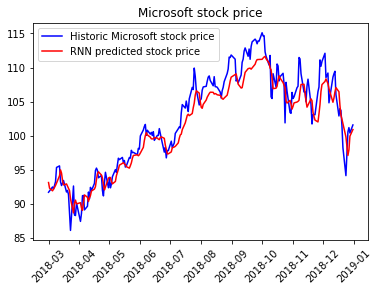

In [60]:
plt.plot(test[40:]['Adj_Close'], color = 'blue', label = 'Historic Microsoft stock price')
plt.plot(test[40:]['Adj_Close'].index, predicted_stock_price, color = 'red', label = 'RNN predicted stock price')
plt.xticks(rotation=45)
plt.title('Microsoft stock price')
plt.legend()
plt.show()

I would like to compare RNN model against a very simple model. For example using 10 previous daily stock prices and extrpolating this into the following day.

In [21]:
predicted_simple_1 = []
for i in range(40, len(test)):
    predicted_simple_1.append(test.iloc[i-1, 0] + (test.iloc[i-1, 0] - test.iloc[i-11, 0])/10)
predicted_simple_1 = np.array(predicted_simple_1)
    
predicted_simple_2 = []
for i in range(40, len(test)):
    predicted_simple_2.append(test.iloc[i-1, 0] + (test.iloc[i-1, 0] - test.iloc[i-4, 0])/3)
predicted_simple_2 = np.array(predicted_simple_2)

The below chart shows that simple model is actually better predicting stock prices than RNN which means there is some room for RNN tuning.

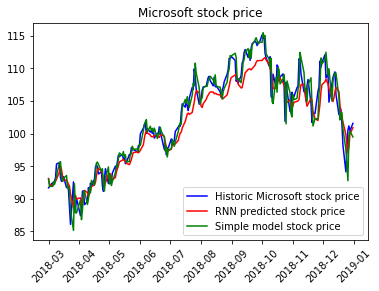

In [63]:
plt.plot(test[40:]['Adj_Close'], color = 'blue', label = 'Historic Microsoft stock price')
plt.plot(test[40:]['Adj_Close'].index, predicted_stock_price, color = 'red', label = 'RNN predicted stock price')
plt.plot(test[40:]['Adj_Close'].index, predicted_simple_1, color = 'green', label = 'Simple model stock price')
plt.xticks(rotation=45)
plt.title('Microsoft stock price')
plt.legend()
plt.show()

Mean squared error of RNN model is higher than compared vs "simple" model

In [64]:
compare_dt = test[40:][['Adj_Close']]
compare_dt.rename(columns={compare_dt.columns[0]: 'Actual'}, inplace=True)
compare_dt['RNN'] = predicted_stock_price
compare_dt['Simple1'] = predicted_simple_1
compare_dt['Simple2'] = predicted_simple_2
compare_dt['RNN_error'] = ((compare_dt.RNN - compare_dt.Actual)/compare_dt.Actual)**2
compare_dt['S1_error'] = ((compare_dt.Simple1 - compare_dt.Actual)/compare_dt.Actual)**2
compare_dt['S2_error'] = ((compare_dt.Simple2 - compare_dt.Actual)/compare_dt.Actual)**2
compare_dt[['RNN_error', 'S1_error', 'S2_error']].sum()

RNN_error    0.097176
S1_error     0.072468
S2_error     0.089910
dtype: float64

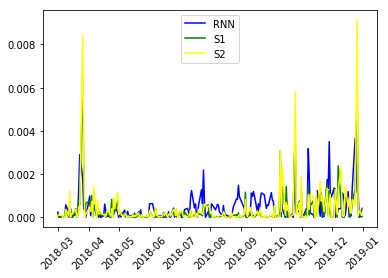

In [65]:
plt.plot(compare_dt['RNN_error'], color='blue', label='RNN')
plt.plot(compare_dt['S1_error'], color='green', label='S1')
plt.plot(compare_dt['S2_error'], color='yellow', label='S2')
plt.legend()
plt.xticks(rotation=45)
plt.show()